## 1. Import Libraries

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

## 2. Load and Pre-process Dataset

### 2.1 Reading the Dataset

In [4]:
# Load the training and testing datasets separately
train_data = pd.read_csv("data/fraudTrain.csv", encoding='ascii', index_col='Unnamed: 0')
test_data = pd.read_csv("data/fraudTest.csv", encoding='ascii', index_col='Unnamed: 0')

In [5]:
train_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
test_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### 2.2 Converting Date into datetime

In [7]:
# Convert 'trans_date_trans_time' and 'dob' to datetime
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['dob'] = pd.to_datetime(train_data['dob'])

test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])
test_data['dob'] = pd.to_datetime(test_data['dob'])

### 2.3 Missing Values in the dataset and description of the dataset

In [8]:
# Check for missing values
train_missing_values = train_data.isnull().sum()

test_missing_values = test_data.isnull().sum()

In [9]:
# Describe the numerical features
train_numerical_description = train_data.describe()

test_numerical_description = test_data.describe()

In [10]:
train_numerical_description

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud
count,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,2019-10-03 12:47:28.070214144,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1973-10-03 19:02:55.017178512,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
min,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1924-10-30 00:00:00,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,2019-06-03 19:12:22.500000,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1962-08-13 00:00:00,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,2019-10-03 07:35:47,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1975-11-30 00:00:00,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,2020-01-28 15:02:55.500000,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1987-02-22 00:00:00,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,2005-01-29 00:00:00,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00
std,NaN,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,NaN,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02


In [11]:
test_numerical_description

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud
count,555719,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,2020-10-02 01:54:25.166780672,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1973-11-11 16:30:05.937173264,1.380679e+09,38.542798,-90.231380,0.003860
min,2020-06-21 12:14:25,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1924-10-30 00:00:00,1.371817e+09,19.027422,-166.671575,0.000000
25%,2020-08-09 06:10:27.500000,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1962-09-27 00:00:00,1.376029e+09,34.755302,-96.905129,0.000000
50%,2020-10-03 00:59:48,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1975-11-30 00:00:00,1.380762e+09,39.376593,-87.445204,0.000000
75%,2020-12-01 03:03:04,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1987-04-23 00:00:00,1.385867e+09,41.954163,-80.264637,0.000000
max,2020-12-31 23:59:34,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,2005-01-29 00:00:00,1.388534e+09,66.679297,-66.952026,1.000000
std,NaN,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,NaN,5.201104e+06,5.095829,13.733071,0.062008


In [12]:
def describe_categorical(data):
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Get the number of unique values and the most frequent categories for each categorical column
    categorical_insights = {}
    for col in categorical_columns:
        categorical_insights[col] = {
            'unique_values': data[col].nunique(),
            'most_frequent_category': data[col].value_counts().idxmax(),
            'frequency': data[col].value_counts().max()
        }
    
    return categorical_insights

In [13]:
# Describe the categorical features
train_categorical_description = describe_categorical(train_data)
test_categorical_description = describe_categorical(test_data)

In [14]:
train_categorical_description

{'merchant': {'unique_values': 693,
  'most_frequent_category': 'fraud_Kilback LLC',
  'frequency': 4403},
 'category': {'unique_values': 14,
  'most_frequent_category': 'gas_transport',
  'frequency': 131659},
 'first': {'unique_values': 352,
  'most_frequent_category': 'Christopher',
  'frequency': 26669},
 'last': {'unique_values': 481,
  'most_frequent_category': 'Smith',
  'frequency': 28794},
 'gender': {'unique_values': 2,
  'most_frequent_category': 'F',
  'frequency': 709863},
 'street': {'unique_values': 983,
  'most_frequent_category': '0069 Robin Brooks Apt. 695',
  'frequency': 3123},
 'city': {'unique_values': 894,
  'most_frequent_category': 'Birmingham',
  'frequency': 5617},
 'state': {'unique_values': 51,
  'most_frequent_category': 'TX',
  'frequency': 94876},
 'job': {'unique_values': 494,
  'most_frequent_category': 'Film/video editor',
  'frequency': 9779},
 'trans_num': {'unique_values': 1296675,
  'most_frequent_category': '0b242abb623afc578575680df30655b9',
  '

In [15]:
test_categorical_description

{'merchant': {'unique_values': 693,
  'most_frequent_category': 'fraud_Kilback LLC',
  'frequency': 1859},
 'category': {'unique_values': 14,
  'most_frequent_category': 'gas_transport',
  'frequency': 56370},
 'first': {'unique_values': 341,
  'most_frequent_category': 'Christopher',
  'frequency': 11443},
 'last': {'unique_values': 471,
  'most_frequent_category': 'Smith',
  'frequency': 12146},
 'gender': {'unique_values': 2,
  'most_frequent_category': 'F',
  'frequency': 304886},
 'street': {'unique_values': 924,
  'most_frequent_category': '444 Robert Mews',
  'frequency': 1474},
 'city': {'unique_values': 849,
  'most_frequent_category': 'Birmingham',
  'frequency': 2423},
 'state': {'unique_values': 50,
  'most_frequent_category': 'TX',
  'frequency': 40393},
 'job': {'unique_values': 478,
  'most_frequent_category': 'Film/video editor',
  'frequency': 4119},
 'trans_num': {'unique_values': 555719,
  'most_frequent_category': '2da90c7d74bd46a0caf3777415b3ebd3',
  'frequency': 1

### 2.4 Outlier Detection

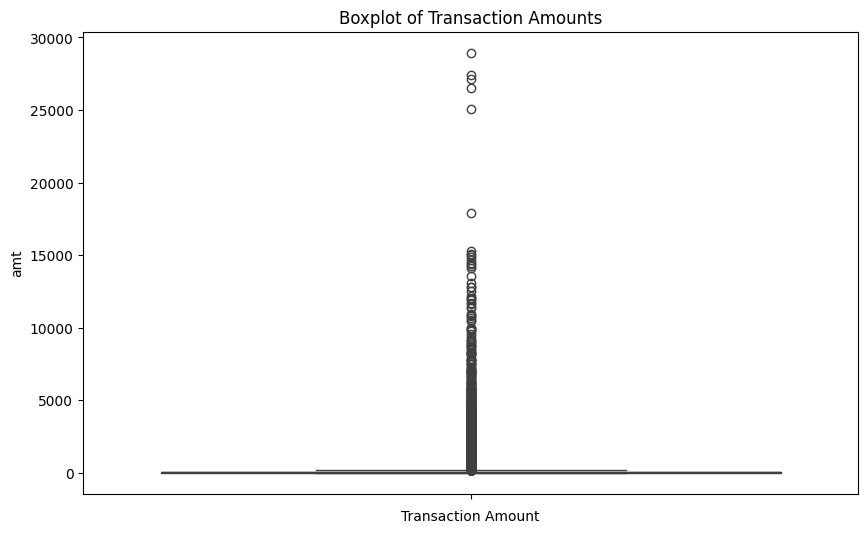

In [16]:
# Check for outliers in the 'amt' column using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(train_data['amt'])
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

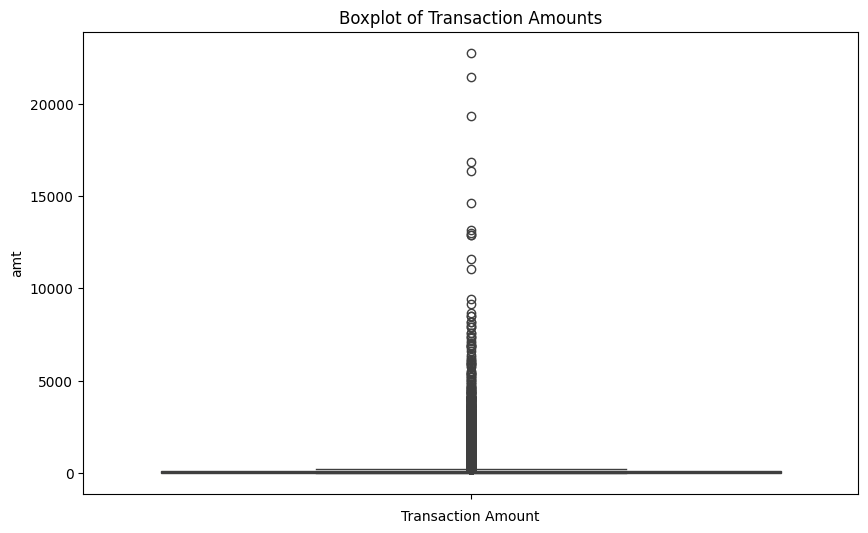

In [17]:
# Check for outliers in the 'amt' column using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(test_data['amt'])
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

### 2.5 Distribution of Target Variable

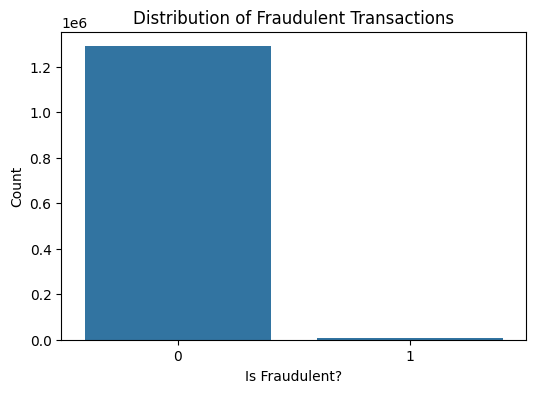

In [18]:
# Explore the distribution of the target variable 'is_fraud'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=train_data)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraudulent?')
plt.ylabel('Count')
plt.show()

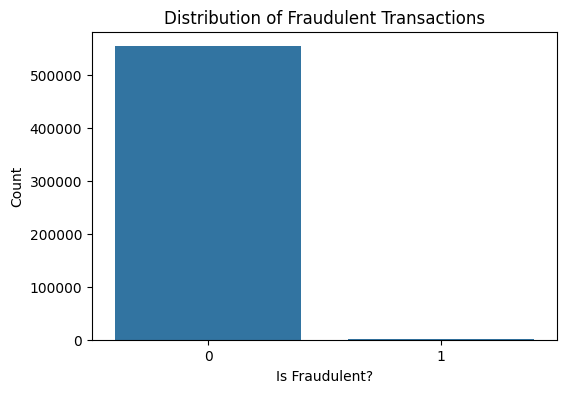

In [19]:
# Explore the distribution of the target variable 'is_fraud'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=test_data)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraudulent?')
plt.ylabel('Count')
plt.show()

### 2.6 Distribution of features important for Model

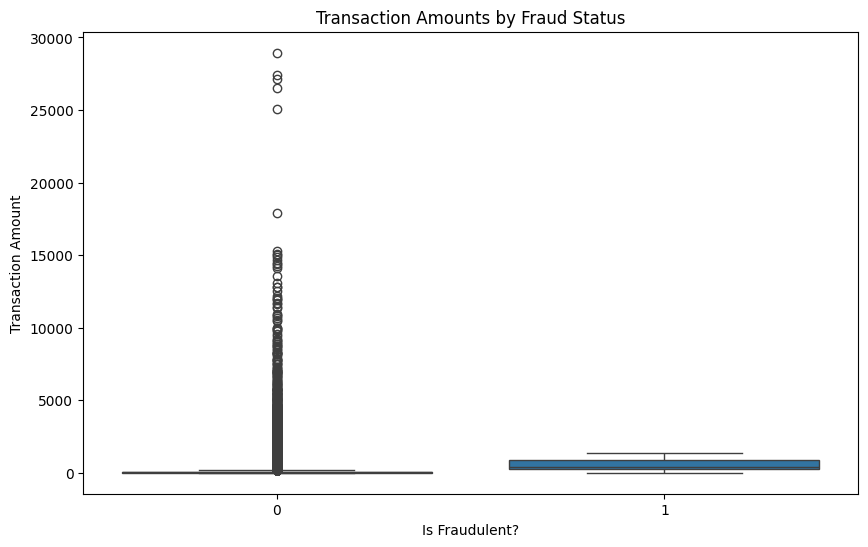

In [20]:
# Explore the distribution of transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=train_data)
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Is Fraudulent?')
plt.ylabel('Transaction Amount')
plt.show()

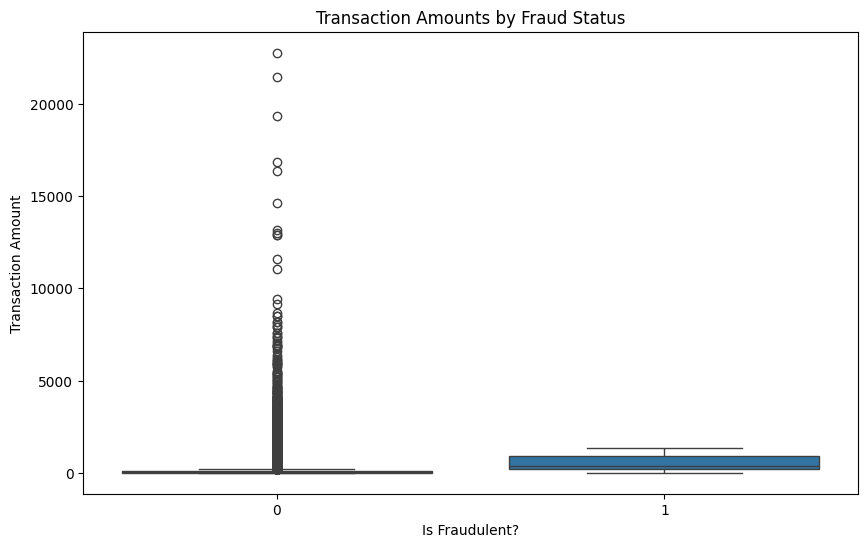

In [21]:
# Explore the distribution of transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=test_data)
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Is Fraudulent?')
plt.ylabel('Transaction Amount')
plt.show()

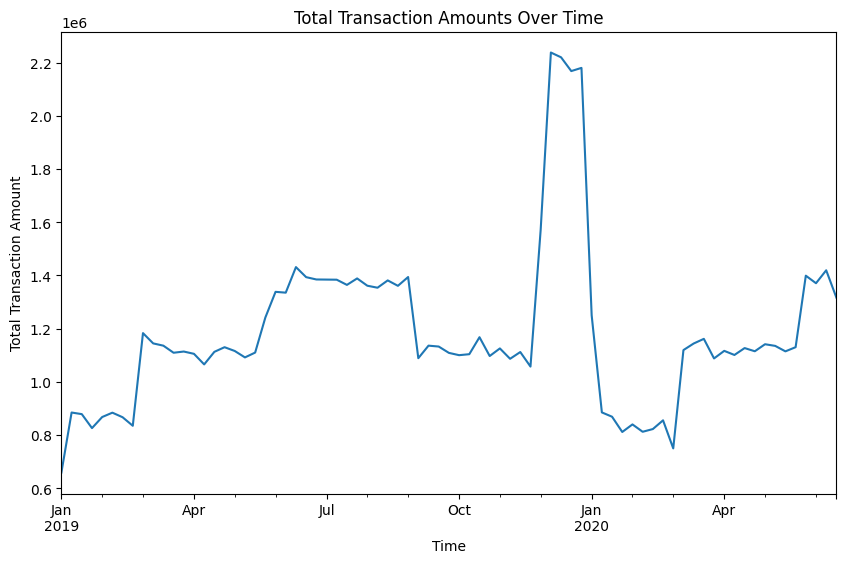

In [22]:
# Explore the distribution of transaction amounts over time
plt.figure(figsize=(10, 6))
train_data.set_index('trans_date_trans_time')['amt'].resample('W').sum().plot()
plt.title('Total Transaction Amounts Over Time')
plt.xlabel('Time')
plt.ylabel('Total Transaction Amount')
plt.show()

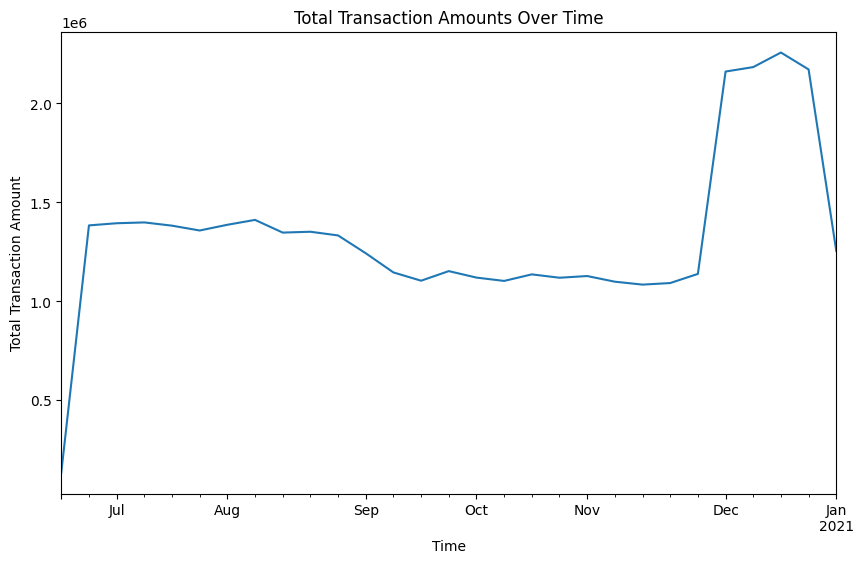

In [23]:
# Explore the distribution of transaction amounts over time
plt.figure(figsize=(10, 6))
test_data.set_index('trans_date_trans_time')['amt'].resample('W').sum().plot()
plt.title('Total Transaction Amounts Over Time')
plt.xlabel('Time')
plt.ylabel('Total Transaction Amount')
plt.show()

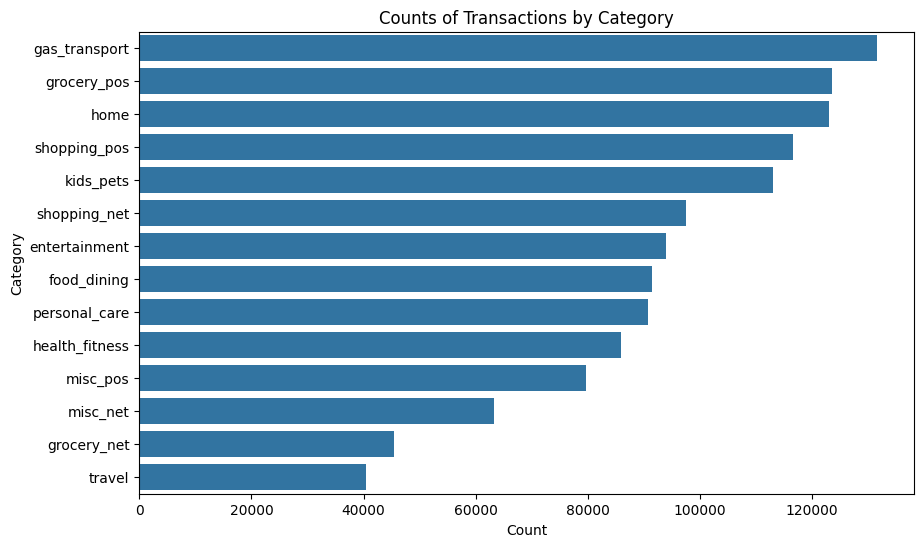

In [24]:
# Explore the categories of transactions
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=train_data, order = train_data['category'].value_counts().index)
plt.title('Counts of Transactions by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

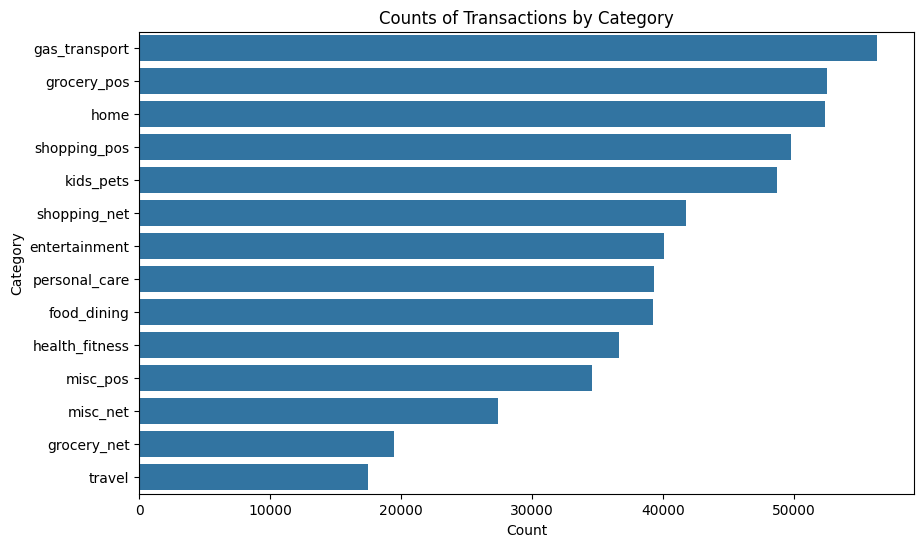

In [25]:
# Explore the categories of transactions
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=test_data, order = test_data['category'].value_counts().index)
plt.title('Counts of Transactions by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### 2.7 Feature Engineering

This brings the ratio of non-fraudulent to fraudulent transactions to approximately 10:1, which is more balanced than before but still reflects the rarity of fraudulent transactions.

In [26]:
# Creating some time-based features
def create_features(df):
    # Create time-based features
    # Extract hour of the day and day of the week from 'trans_date_trans_time'
    df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    
    # Separate majority and minority classes
    df_majority = df[df.is_fraud==0]
    df_minority = df[df.is_fraud==1]
    
    # Upsample minority class
    # We will upsample to 10% of the majority class for a start to keep the dataset size manageable
    minority_upsampled = resample(df_minority,
                               replace=True,
                               n_samples=int(len(df_majority) * 0.1),
                               random_state=123)

    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, minority_upsampled])
    
    # Display new class counts
    return df_upsampled

In [27]:
train_upsampled = create_features(train_data)
test_unsampled = create_features(test_data)

In [28]:
# Display new class counts
print('Class distribution after resampling:')
print(train_upsampled.is_fraud.value_counts())

# Display head of the new dataframe with additional features
print('Head of the dataframe with new time-based features:')
print(train_upsampled[['hour_of_day', 'day_of_week', 'is_fraud']].head())

Class distribution after resampling:
is_fraud
0    1289169
1     128916
Name: count, dtype: int64
Head of the dataframe with new time-based features:
   hour_of_day  day_of_week  is_fraud
0            0            1         0
1            0            1         0
2            0            1         0
3            0            1         0
4            0            1         0


In [29]:
# Display new class counts
print('Class distribution after resampling:')
print(test_unsampled.is_fraud.value_counts())

# Display head of the new dataframe with additional features
print('Head of the dataframe with new time-based features:')
print(test_unsampled[['hour_of_day', 'day_of_week', 'is_fraud']].head())

Class distribution after resampling:
is_fraud
0    553574
1     55357
Name: count, dtype: int64
Head of the dataframe with new time-based features:
   hour_of_day  day_of_week  is_fraud
0           12            6         0
1           12            6         0
2           12            6         0
3           12            6         0
4           12            6         0


In [55]:
train_upsampled.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour_of_day,day_of_week
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


## 3. Model Training and Predictions

### 3.1 Selecting Train-data features and Target variable

In [57]:
# Select features and target variable, excluding 'age' and 'distance'
X_train = train_upsampled.drop(['is_fraud', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'trans_num', 'unix_time', 'dob'], axis=1)
y_train = train_upsampled['is_fraud']

#### 3.2 Scaling Numeric features and One-Hot Encoding Categorical features

In [58]:
# List of categorical columns to be encoded
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# List of numerical columns to be scaled
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

### 3.3 Creating Random Forest Classifier

In [59]:
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Create a full pipeline with our preprocessor and the classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])

### 3.4 Training the Classifier

In [60]:
# Train the classifier
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amt', 'zip', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job'])])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

### 3.5 Selecting Test-data features and Target variable

In [61]:
# Prepare the test data
X_test = test_unsampled.drop(['is_fraud', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'trans_num', 'unix_time', 'dob'], axis=1)
y_test = test_unsampled['is_fraud']

### 3.6 Predicting on Test data

In [62]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

## 4. Evaluation of the Model

In [63]:
# Evaluate the classifier
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the classification report and confusion matrix
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    553574
           1       0.98      0.48      0.65     55357

    accuracy                           0.95    608931
   macro avg       0.97      0.74      0.81    608931
weighted avg       0.95      0.95      0.94    608931

Confusion Matrix:
[[553119    455]
 [ 28519  26838]]


In [64]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9524182542849683
Precision: 0.9833290587330085
Recall: 0.48481673501092903
F1 Score: 0.6494373865698729
ROC AUC: 0.7419974016725315


## 5. Finding Best parameters for the model 

In [65]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Initialize the Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Fit the model
random_search.fit(X_train_preprocessed, y_train)

# Print the best parameters and the corresponding score
print('Best parameters found:\
', random_search.best_params_)
print('Best score:', random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=48, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time= 6.2min
[CV] END max_depth=48, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time= 6.3min
[CV] END max_depth=48, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time= 6.0min
[CV] END max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=174; total time= 3.4min
[CV] END max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=174; total time= 3.5min
[CV] END max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=174; total time= 3.3min
[CV] END max_depth=33, min_samples_leaf=4, min_samples_split=9, n_estimators=123; total time= 3.1min
[CV] END max_depth=33, min_samples_leaf=4, min_samples_split=9, n_estimators=123; total time= 3.0min
[CV] END max_depth=33, min_samples_leaf=4, min_samples_split=9, n_estimators=123; total time= 2.9min
[CV] END max_depth=12